In [1]:
!pip install prophet

In [2]:
# Import required dependencies
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from IPython.display import clear_output
import numpy as np
import time
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns

In [3]:
#Read in the dataset and import csv file in a DataFrame ("df")
df=pd.read_csv('https://docs.google.com/spreadsheets/d/1_ODNIn5n1k9RSVr_7gV2On4idZ6v0B2XPeMhCD18kio/pub?gid=1188863554&single=true&output=csv')
    #df.head()

# create a new "cheif_term" column and add to the "df" DataFrame
chiefs = df['chief'].unique()
x = 0
for chief in chiefs:
    #print(chief)
    df.loc[df['chief'] == chief, 'chief_term'] = x
    #dfcoyp['chief_term'] = x
    x = x + 1

# print preview of "df" DataFrame
df.head()

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,...,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes,chief_term
0,2021-036,2021-036-01,2021-036-01-01,2021-036-01-01-01,1/13/2022,6,NaN,142 S. Ct. 647,211 L. Ed. 2d 433,2022 U.S. LEXIS 495,...,NaN,3.0,309.0,NaN,NaN,111.0,1,5,4,0.0
1,2021-036,2021-036-01,2021-036-01-01,2021-036-01-01-01,1/13/2022,6,NaN,142 S. Ct. 647,211 L. Ed. 2d 433,2022 U.S. LEXIS 495,...,NaN,3.0,309.0,NaN,NaN,111.0,1,5,4,0.0
2,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,NaN,6.0,600.0,35 U.S.C. ¤ 33,78.0,78.0,1,8,1,1.0
3,1946-002,1946-002-01,1946-002-01-01,1946-002-01-01-01,11/18/1946,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,...,NaN,6.0,600.0,18 U.S.C. ¤ 398,81.0,87.0,1,6,3,1.0
4,1946-002,1946-002-02,1946-002-02-01,1946-002-02-01-01,11/18/1946,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,...,NaN,6.0,600.0,18 U.S.C. ¤ 398,81.0,87.0,1,6,3,1.0


In [4]:
# Review data types and shape of "df"
print(f'Data Types: \n{df.dtypes}\n\n DataFrame Shape: {df.shape}')

Data Types: 
caseId                       object
docketId                     object
caseIssuesId                 object
voteId                       object
dateDecision                 object
decisionType                  int64
usCite                       object
sctCite                      object
ledCite                      object
lexisCite                    object
term                          int64
naturalCourt                  int64
chief                        object
docket                       object
caseName                     object
dateArgument                 object
dateRearg                    object
petitioner                  float64
petitionerState             float64
respondent                  float64
respondentState             float64
jurisdiction                float64
adminAction                 float64
adminActionState            float64
threeJudgeFdc               float64
caseOrigin                  float64
caseOriginState             float64
caseSource     

In [5]:
#change decision date to DT for data exploration
df['dateDecision'] = pd.to_datetime(df['dateDecision'], errors='coerce')

In [6]:
#create a year column for easier sorting and aggregation in visualizations
df['yearDecision'] = df['dateDecision'].dt.year

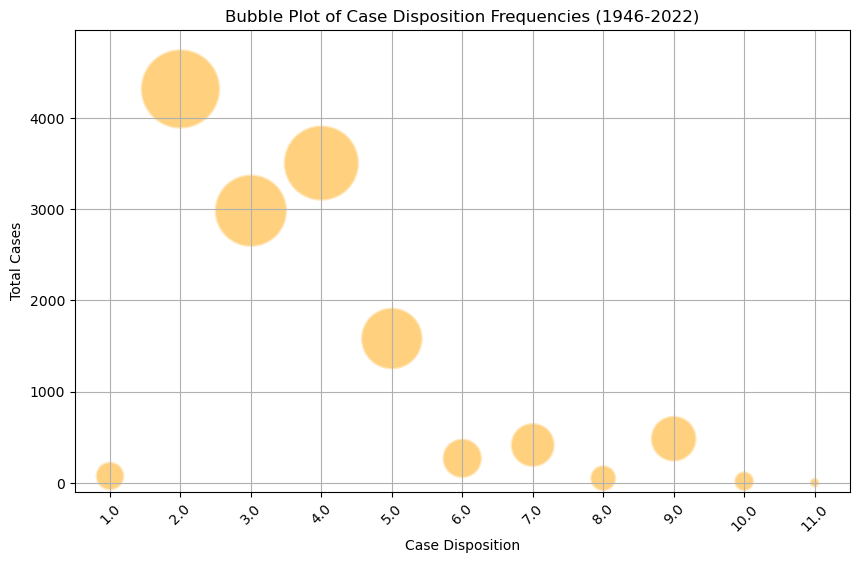

In [7]:
# Exploration Question #1: What is the most common caseDisposition? 

# Visualize the most frequest caseDisposition over total data set (not just by year) using a Bubble Plot

# Filter the DataFrame by Case Disposition and create a count column for a total count of each CD classes
case_disposition_counts = df['caseDisposition'].value_counts()
case_disposition_counts_df = pd.DataFrame(case_disposition_counts).reset_index()

# Create the bubble plot

# Create components of bubble plot (normalize bubble size for better viewing)
case_disposition_classes = case_disposition_counts_df['caseDisposition']
volume_of_cases = case_disposition_counts_df['count']
bubble_size = bubble_sizes = np.sqrt(volume_of_cases)  * 50

plt.figure(figsize=(10, 6))
plt.scatter(
    case_disposition_classes, 
    volume_of_cases,
    s = bubble_size,  
    alpha=0.5,  
    c='orange',  
    edgecolors='w',  
    linewidth=2  
)
# Set the title and labels
plt.title('Bubble Plot of Case Disposition Frequencies (1946-2022)')
plt.xlabel('Case Disposition')
plt.ylabel('Total Cases')

#Fix x-axis display and use caseDisposition values as tick positions
x_ticks = case_disposition_classes
plt.xticks(ticks=x_ticks, labels=x_ticks, rotation=45)  # Rotate labels if needed for readability

#Fix y-axis dispaly to view whole bubble (set a little below zero and 15% above maximum)
plt.ylim(-100, max(volume_of_cases) * 1.15)  

#save the plot to outputs folder

plt.savefig('outputs/case_disposition_bubble_plot.png')
# Show the plot
plt.grid(True)
plt.show()

In [8]:
# Exploration Question #2: Have case dispositions changed over time?

# Determine the most frequent Case Disposition Classification by Year
# Filter the DataFrame by Year and Case Disposition and create a mode column for most frequent classification of CD
# Apply function to account for multiple modes (select first) and no mode (fill with NaN)
case_disposition_mode = df.groupby('yearDecision')['caseDisposition'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
case_disposition_mode_df = pd.DataFrame(case_disposition_mode)
# reset the index and preview
case_disposition_mode_df = case_disposition_mode_df.reset_index()
case_disposition_mode_df.head()

,yearDecision,caseDisposition
0,1946,2.0
1,1947,2.0
2,1948,2.0
3,1949,2.0
4,1950,2.0


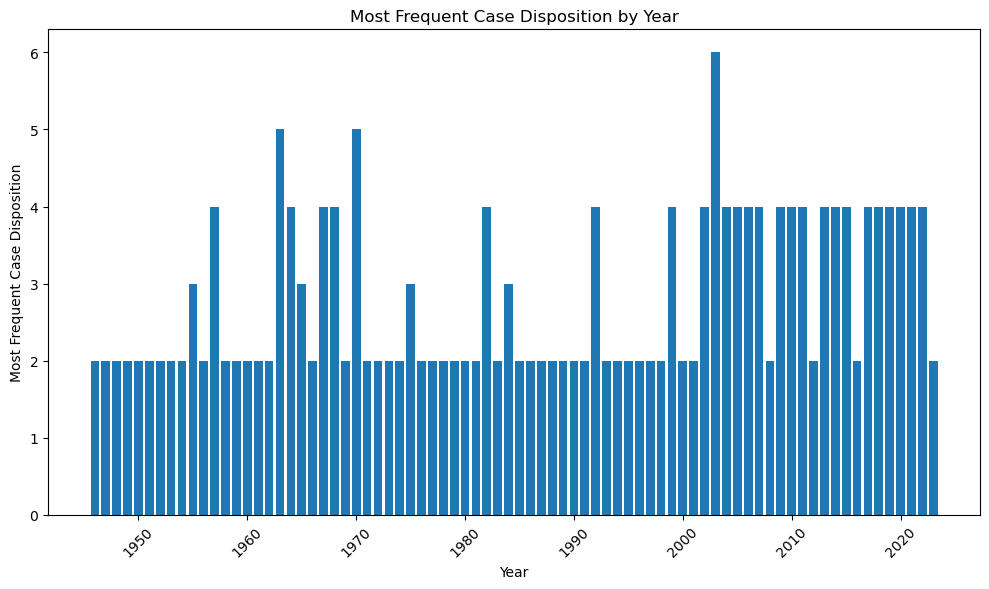

In [9]:
# visualize the mode by year with a bar graph and save image to outputs file
plt.figure(figsize=(10, 6)) 
plt.bar(case_disposition_mode_df['yearDecision'], case_disposition_mode_df['caseDisposition'])
# add labels
plt.xlabel('Year')  
plt.ylabel('Most Frequent Case Disposition') 
plt.title('Most Frequent Case Disposition by Year') 
# format to improve readability of x-axis and graph

plt.xticks(rotation=45)  
plt.tight_layout()  

plt.savefig('outputs/case_disposition_by_year.png')
plt.show()

In [10]:
# Exploration Question #3: How have case dispositions changed over time, based on who is serving as Chief Justice?
# Filter the DataFrame by Term of Chief Justice and Case Disposition
chief_counts = df.groupby(['chief'])['caseDisposition'].value_counts()
chief_counts_df = pd.DataFrame(chief_counts)
chief_counts_df.head()

count
chief  caseDisposition       
Burger 2.0               1257
       3.0               1048
       4.0               1005
       5.0                506
       7.0                134

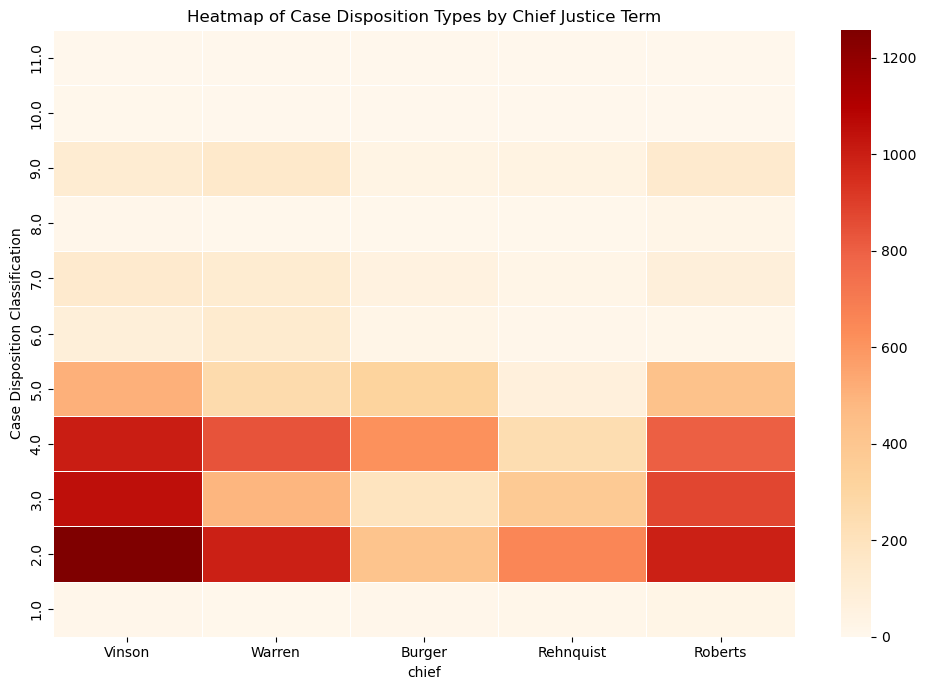

In [11]:
# Create a pivot table for plotting
pivot_df2 = chief_counts_df.pivot_table(index='caseDisposition', columns=['chief'], values='count', fill_value=0)

# Fix index for display purposes
pivot_df2 = pivot_df2.sort_index(ascending=False)

# Plot the heatmap
plt.figure(figsize=(10, 7))
ax1 = sns.heatmap(pivot_df2, annot=False, cmap='OrRd', cbar=True, linewidths=.5)

# Add labels and format
plt.title('Heatmap of Case Disposition Types by Chief Justice Term')
ax1.set_xticklabels(['Vinson', 'Warren', 'Burger', 'Rehnquist', 'Roberts'] * (pivot_df2.shape[1] // 5))
plt.ylabel('Case Disposition Classification')
plt.tight_layout()  
# Save the plot
plt.savefig('outputs/heatmap_cd_cjterm.png')
# Show the heatmap plot
plt.show()

In [12]:
#Exploration Question #4: Can we categorize the overall tone of case decisions based on the term of the chief justice?
# Filter the DataFrame by Term of Chief Justice and Decision Direction and add a count column for DD classes
chief_counts_dd = df.groupby(['chief_term', 'chief'])['decisionDirection'].value_counts()
chief_counts_dd_df = pd.DataFrame(chief_counts_dd)
chief_counts_dd_df.head()

count
chief_term chief   decisionDirection       
0.0        Roberts 1.0                  871
                   2.0                  777
                   3.0                   36
1.0        Vinson  1.0                  732
                   2.0                  669

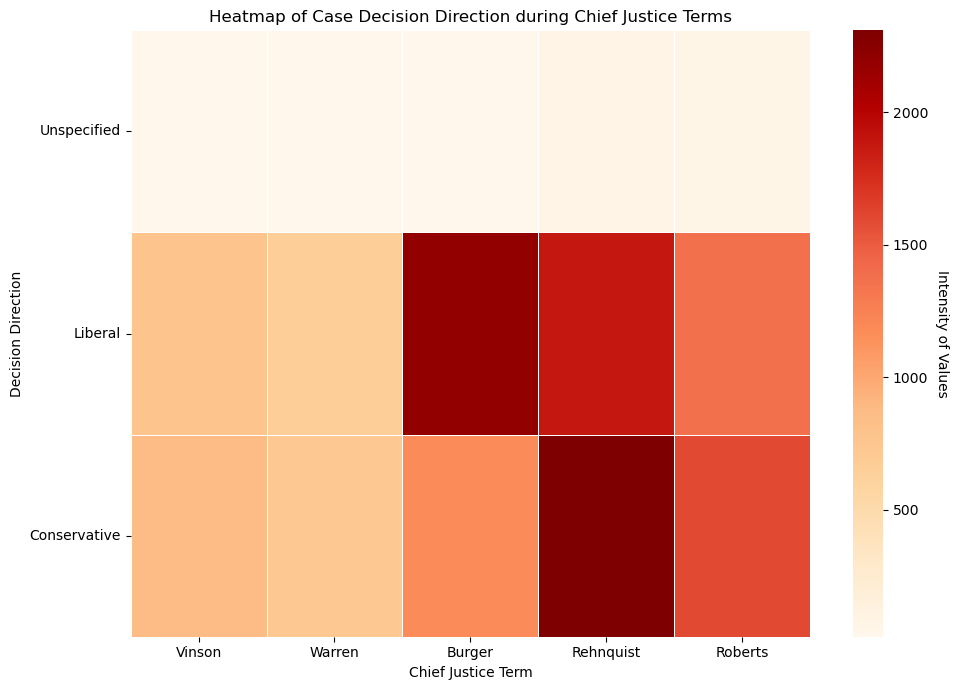

In [13]:
# Pivot the DataFrame to get counts for each direction per term
pivot_dd_index = chief_counts_dd_df.pivot_table(index='decisionDirection', columns='chief_term', values='count', fill_value=0)
pivot_dd = pivot_dd_index.sort_index(ascending=False)

# Plot the heatmap and save as a variable for customization
plt.figure(figsize=(10, 7))
ax = sns.heatmap(pivot_dd, cmap="OrRd", cbar=True, linewidths=.5)

# Center x-tick and y-tick in middle (rather than at classification's numerical position)
ax.set_xticks(np.arange(pivot_dd.shape[1]) + 0.5)
ax.set_yticks(np.arange(pivot_dd.shape[0]) + 0.5)

# Change x-tick and y-tick labels from numerical classification to corresponding text value and format 
ax.set_xticklabels(['Vinson', 'Warren', 'Burger', 'Rehnquist', 'Roberts'] * (pivot_dd.shape[1] // 5))
ax.set_yticklabels(["Unspecified", "Liberal", "Conservative"], rotation=0)

# Customize the color bar (legend)
colorbar = ax.collections[0].colorbar
colorbar.set_label('Intensity of Values', rotation=270, labelpad=15)

# Customize the plot
plt.title('Heatmap of Case Decision Direction during Chief Justice Terms')
plt.xlabel('Chief Justice Term')
plt.ylabel('Decision Direction')
plt.tight_layout()  # Adjust layout to fit labels
#save the plot
plt.savefig('outputs/heatmap_dd_cjterm.png')
# Show the plot
plt.show()

In [14]:
#Exploration Question #5: Can we predict the overall tone of future decisions?
#creating dataframe for using in projection modeling
dd_by_date_df = pd.DataFrame(df[['dateDecision','decisionDirection']])
dd_by_date_df.tail()

,dateDecision,decisionDirection
13851,2023-06-22,2.0
13852,2023-06-22,2.0
13853,2023-05-25,1.0
13854,2023-05-22,1.0
13855,2023-06-23,1.0


In [15]:
#change columns names for dd Dataframe for projections
dd_by_date_df.columns = ["ds", "y"]
dd_by_date_df.tail()

,ds,y
13851,2023-06-22,2.0
13852,2023-06-22,2.0
13853,2023-05-25,1.0
13854,2023-05-22,1.0
13855,2023-06-23,1.0


13:29:13 - cmdstanpy - INFO - Chain [1] start processing
13:29:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\dipes\anaconda_3\envs\dev1\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
c:\Users\dipes\anaconda_3\envs\dev1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\dipes\anaconda_3\envs\dev1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(

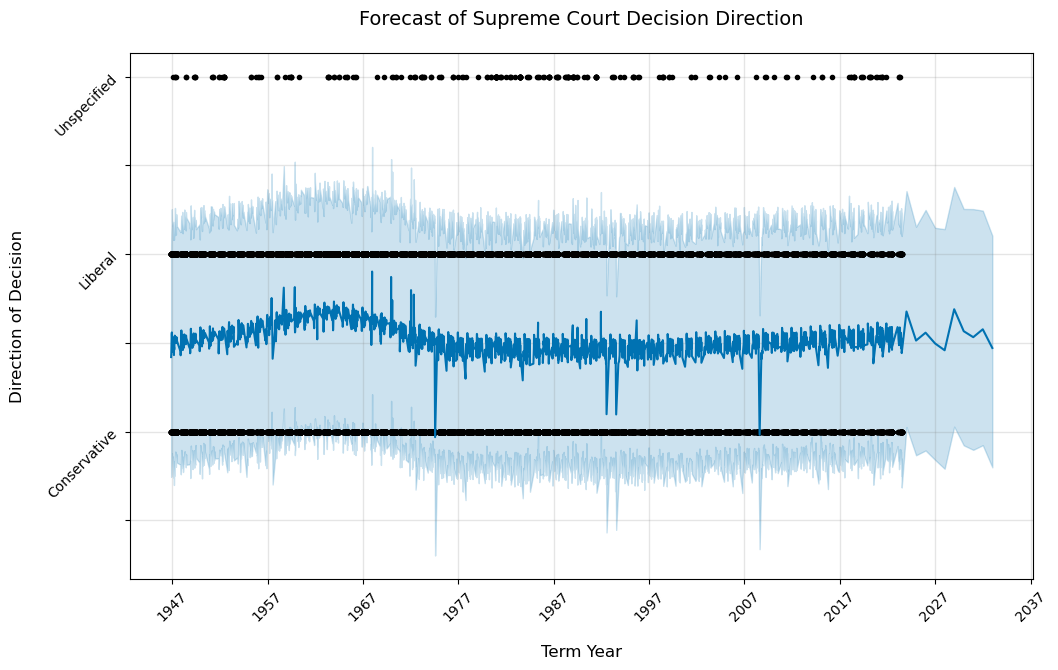

In [16]:
#creating variables forecasting period and frequency (years)
forecasting_period = 10
forecasting_frequency = 'Y'

# Create a Prophet model
model = Prophet()

# Fit the model to the data
model.fit(dd_by_date_df)

# Create a future dataframe for prediction
future = model.make_future_dataframe(periods=forecasting_period, freq=forecasting_frequency)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)

# FORMAT AXES

# Access the axes
ax = fig.gca()

# Label x-axis, y-axis, and titles
ax.set_xlabel('Term Year', fontsize=12, labelpad=15)  
ax.set_ylabel('Direction of Decision', fontsize=12, labelpad=15)
ax.set_title('Forecast of Supreme Court Decision Direction', fontsize=14, pad=20)  # Set plot title

# Label x-ticks and y-ticks
ax.tick_params(axis='x', rotation=45)  

ax.tick_params(axis='y', labelsize=10) 
new_labels = [' ', ' ', 'Conservative', '', 'Liberal', '', 'Unspecified']
ax.set_yticklabels(new_labels, rotation=45, fontsize=10)

# save the plot
plt.savefig('outputs/forecast_dd.png')

# Show the plot
plt.show()

c:\Users\dipes\anaconda_3\envs\dev1\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\dipes\anaconda_3\envs\dev1\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\dipes\anaconda_3\envs\dev1\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

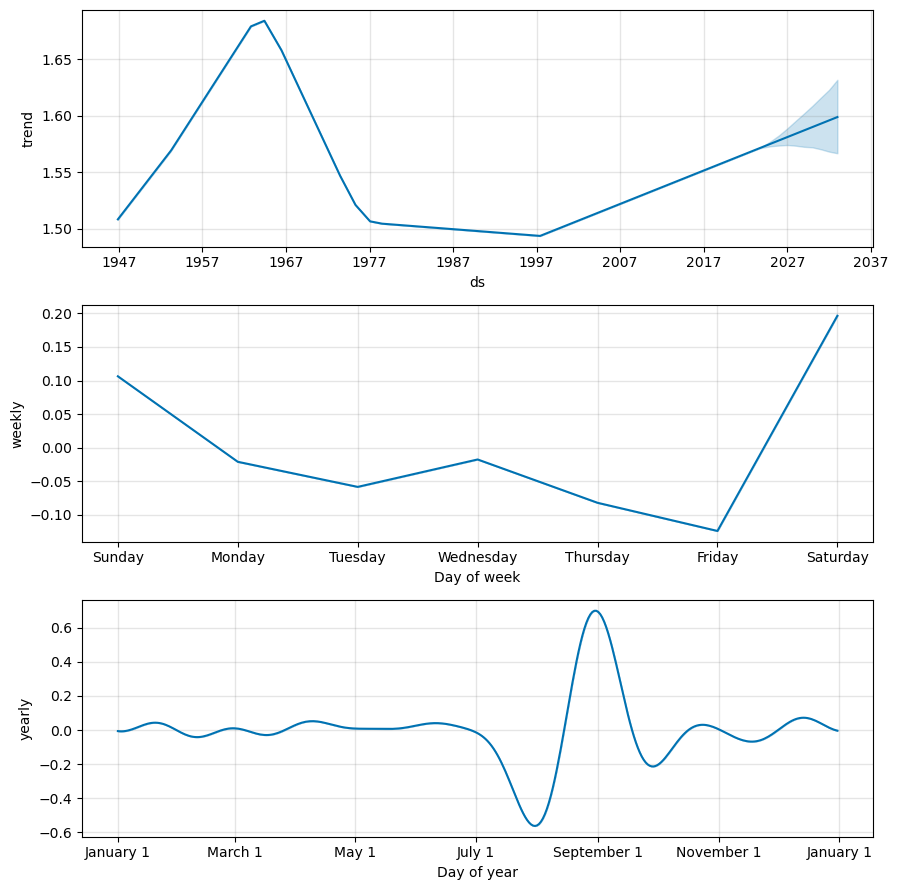

In [17]:
# plot the components
fig = model.plot_components(forecast)
# save the component plot
plt.savefig('outputs/forecast_dd_components.png')
# Show the plot
plt.show()

In [18]:
#Create a new working DataFrame from original "df" called "dfwork" with reduced columns
dfwork = df[[
#"issueArea",
"decisionDirection",
"decisionType",
"threeJudgeFdc",
"certReason",
#"lcDisposition",
"lcDispositionDirection",
"partyWinning",
"majVotes",
"chief_term",
"minVotes",
"caseDisposition"
]]

In [19]:
# Create a correlation table to view relationship between variables
corr_df = dfwork.corr()
# save correlation csv to outputs file
corr_df.to_csv('outputs/correlation.csv', index=False)
corr_df

,decisionDirection,decisionType,threeJudgeFdc,certReason,lcDispositionDirection,partyWinning,majVotes,chief_term,minVotes,caseDisposition
decisionDirection,1.000000,-0.010765,0.005252,-0.040552,-0.108344,0.094870,0.107677,-0.035575,-0.121187,-0.027196
decisionType,-0.010765,1.000000,0.016747,0.059465,-0.056137,-0.067098,-0.059918,-0.009194,0.049004,0.176046
threeJudgeFdc,0.005252,0.016747,1.000000,-0.396596,0.110345,-0.015413,-0.026777,0.026729,0.029542,0.010968
certReason,-0.040552,0.059465,-0.396596,1.000000,-0.091418,0.098213,-0.032774,-0.068232,0.022651,0.055668
lcDispositionDirection,-0.108344,-0.056137,0.110345,-0.091418,1.000000,0.008546,-0.036939,0.094245,0.052484,-0.034644
partyWinning,0.094870,-0.067098,-0.015413,0.098213,0.008546,1.000000,0.094190,-0.027027,-0.092977,0.296390
majVotes,0.107677,-0.059918,-0.026777,-0.032774,-0.036939,0.094190,1.000000,0.009989,-0.931425,0.109203
chief_term,-0.035575,-0.009194,0.026729,-0.068232,0.094245,-0.027027,0.009989,1.000000,0.017381,0.020606
minVotes,-0.121187,0.049004,0.029542,0.022651,0.052484,-0.092977,-0.931425,0.017381,1.000000,-0.110067
caseDisposition,-0.027196,0.176046,0.010968,0.055668,-0.034644,0.296390,0.109203,0.020606,-0.110067,1.000000


In [20]:
trained_model = None
prompts=pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTcUMWXktcB48qH6B77aGPX1XfrkbBc2_RxzJbmCdtDkUZa2m1orezx1pcrGdvfGytfNQL8L-_58SyP/pub?gid=0&single=true&output=csv")
prompts = prompts.sort_values(by = ['features', 'selection'])
prompts.reset_index(drop=True, inplace=True)
starting_with_0 = ['partyWinning','threeJudgeFdc']
prompts_0 = prompts[prompts['features'].isin(starting_with_0)]
prompts_1 = prompts[~prompts['features'].isin(starting_with_0)]

In [21]:
#model_score = []
#model_scores = pd.DataFrame()


def run_model(target):
    dfwork = df[[
    #"issueArea",
    "decisionDirection",
    "decisionType",
    "threeJudgeFdc",
    "certReason",
    #"lcDisposition",
    "lcDispositionDirection",
    "partyWinning",
    "majVotes",
    "chief_term",
    "minVotes",
    "caseDisposition"
    ]]

    y=df[[target]]
    X = dfwork.drop(columns=y)
    dfwork= dfwork.sort_index(axis=1)
    columns_to_move = ['majVotes', 'minVotes']
    remaining_columns = [col for col in dfwork.columns if col not in columns_to_move]
    dfwork = dfwork[remaining_columns + columns_to_move]

    #reading csv file from link

    #from sklearn.impute import SimpleImputer

    # Impute missing values with the mean
    imputery = SimpleImputer(strategy='constant', fill_value=0)
    #caseDisposition = df[['caseDisposition']]
    y_imputed = imputery.fit_transform(y).reshape(-1)
    #y_imputed = y_imputed.reshape(-1)
    #print(y_imputed)

    #from sklearn.impute import SimpleImputer

    # Impute missing values with the mean
    imputerx = SimpleImputer(strategy='most_frequent')
    X_imputed = pd.DataFrame(imputerx.fit_transform(X), columns=X.columns)
    #print(X_imputed)
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, random_state=42)
    #clear_output()
    return X_train, X_test, y_train, y_test, target

def models(X_train, X_test, y_train, y_test, target):
    knn(X_train, X_test, y_train, y_test, target)
    lr(X_train, X_test, y_train, y_test, target)
    rf(X_train, X_test, y_train, y_test, target)
    dt(X_train, X_test, y_train, y_test, target)
    #return X_train, X_test, y_train, y_test, target
    #return rt_model

#    return X_train, X_test, y_train, y_test, target
    
    # Create the KNN model with 9 neighbors


def knn(X, xt,y, yt, target):
    model = KNeighborsClassifier(n_neighbors=10)
    model_name = 'KNN'
    function_name = 'knn'
    # Fit the model to the training data
    model.fit(X, y)

    #using score function to find training and testing score
    train_score = model.score(X, y)
    test_score = model.score(xt, yt)
    predictions = model.predict(xt)
    acc_score = accuracy_score(yt, predictions)
    #display(f"{model_name} Train/Test Score for {target} column : {train_score:.3f}/{test_score:.3f}")
    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    #return knn_train_score, knn_test_score, target
    return model

def lr(X, xt,y, yt, target):
    # Create the logistic regression classifier model with a random_state of 1
    model = LogisticRegression(max_iter=2000)
    model_name = 'Logistic Regression'
    function_name = 'lr'
    # Fit the model to the training data
    model.fit(X, y)

    train_score = model.score(X, y)
    test_score = model.score(xt, yt)

    # Validate the model by checking the model accuracy with model.score

    #display(f"{model} Train/Test Score for {target} column : {lr_train_score:.3f}/{lr_test_score:.3f}")
    predictions = model.predict(xt)
    # Calculate the accuracy score
    acc_score = accuracy_score(yt, predictions)
    #print(f"Accuracy Score : {acc_score}")

    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    return model

def rf(X, xt,y, yt, target):
    #print(X.columns)
    # Create the logistic regression classifier model with a random_state of 1
    rt_model = RandomForestClassifier(n_estimators=128, random_state=42)
    model_name = 'Random Forest'
    function_name = 'rf'
    # Fit the model to the training data
    rt_model.fit(X, y)
    
    train_score = rt_model.score(X, y)
    test_score = rt_model.score(xt, yt)

    # Validate the model by checking the model accuracy with model.score

    #display(f"{model} Train/Test Score for {target} column : {lr_train_score:.3f}/{lr_test_score:.3f}")
    predictions = rt_model.predict(xt)
    # Calculate the accuracy score
    acc_score = accuracy_score(yt, predictions)
    #print(f"Accuracy Score : {acc_score}")
    #trained_model = model
    #print({trained_model})
    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    return rt_model

def dt(X, xt,y, yt, target):
    from sklearn import tree
    # Create the logistic regression classifier model with a random_state of 1
    model = tree.DecisionTreeClassifier()
    model_name = 'Decision Tree'
    function_name = 'dt'
    # Fit the model to the training data
    model.fit(X, y)

    train_score = model.score(X, y)
    test_score = model.score(xt, yt)

    # Validate the model by checking the model accuracy with model.score

    #display(f"{model} Train/Test Score for {target} column : {lr_train_score:.3f}/{lr_test_score:.3f}")
    predictions = model.predict(xt)
    # Calculate the accuracy score
    acc_score = accuracy_score(yt, predictions)
    #print(f"Accuracy Score : {acc_score}")

    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    return model

def update_score(target, model, fn, trs, tss, acc):
    
    model_score.append({'target_column': target, 'model_name': model, 'function_name' : fn, 'training_score': trs, 'testing_score': tss, 'accuracy_score': acc})
    #display(model_scores.head())
    #return model_scores    

def predict_outcome(trained_model):
    #prompts=pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTcUMWXktcB48qH6B77aGPX1XfrkbBc2_RxzJbmCdtDkUZa2m1orezx1pcrGdvfGytfNQL8L-_58SyP/pub?gid=0&single=true&output=csv")
    #    prompts = prompts.sort_values(by = ['features', 'selection'])
    #    prompts.reset_index(drop=True, inplace=True)
    #    prompts
    #selection_prompts = prompts
    selection1 = np.array([])
    p1s = prompts_1[prompts_1['features']!=target]
    p0s = prompts_0[prompts_0['features']!=target]

    for p1 in p1s['features'].unique():
        #time.sleep(1)

        display(f"Please select a feature from the list of {p1} below:")
        
        for i, feature in enumerate((p1s[p1s['features'] == p1]['value']), start=1):
            display(f"{i}... {feature}")
        selection1 = np.append(selection1,int(input("Enter the number corresponding to your choice: "))).astype(int)
        
        clear_output()

    for p0 in p0s['features'].unique():
        #time.sleep(1)

        display(f"Please select a feature from the list of {p0} below:")
        
        for i, feature in enumerate((p0s[p0s['features'] == p0]['value']), start=0):
            display(f"{i}... {feature}")
        selection1 = np.append(selection1,int(input("Enter the number corresponding to your choice: "))).astype(int)
        
        clear_output()

        #time.sleep(1)

    selection1 = np.append(selection1,int(input("Enter number of majority votes: "))).astype(int)
    selection1 = np.append(selection1,int(input("Enter number of minority votes: "))).astype(int)
    #selection_df = pd.DataFrame(selection1)
    #selection_df = selection_df.T
    #selection_df.loc[0]
    #predict(selection1)
    #return selection1
    selection_df = pd.DataFrame(selection1)
    selection_df = selection_df.T
    selection_df.loc[0]
    #print(selection_df)
    #X_new1 = np.array([X_imputed2.iloc[13853].to_numpy().astype(int)])
    X_new1 = np.array([selection_df.iloc[0].to_numpy().astype(int)])
    #print(X_new1)

    # Get prediction
    #print(model)
    #global trained_model
    #prediction = trained_model.predict(X_new1)
    prediction = trained_model.predict(X_new1)
    #print(f"Based on the data, prediction for the {y.columns[0]} is {prediction[0][0].astype(int)}")
    #print(f"Based on the data, prediction for the {y.columns[1]} is {prediction[0][1].astype(int)}")
    #my_prediction = prompts[(prompts['features'] == y_imputed.columns[0]) & (prompts['selection'] == round(prediction[0][0],0))]['value']
    feature_name = prompts[(prompts['features'] == target) & (prompts['selection'] == round(prediction[0]))]['feature_name'].iloc[0]
    my_prediction = prompts[(prompts['features'] == target) & (prompts['selection'] == round(prediction[0]))]['value'].iloc[0]
    clear_output()
    print(f"Based on my training and analysis of inputs, I predict that outcome of {feature_name} will be : {my_prediction}")

In [22]:
targets = ('partyWinning', 'decisionDirection', 'decisionType', 'caseDisposition')
model_score = []
for target in targets:

    X_train, X_test, y_train, y_test, target = run_model(target)
    models(X_train, X_test, y_train, y_test, target)

model_scores = pd.DataFrame(model_score)

model_scores

,target_column,model_name,function_name,training_score,testing_score,accuracy_score
0,partyWinning,KNN,knn,0.957564,0.954965,0.954965
1,partyWinning,Logistic Regression,lr,0.781370,0.786085,0.786085
2,partyWinning,Random Forest,rf,0.990666,0.976039,0.976039
3,partyWinning,Decision Tree,dt,0.990666,0.970843,0.970843
4,decisionDirection,KNN,knn,0.892513,0.878464,0.878464
5,decisionDirection,Logistic Regression,lr,0.625866,0.622691,0.622691
6,decisionDirection,Random Forest,rf,0.951212,0.925808,0.925808
7,decisionDirection,Decision Tree,dt,0.951309,0.915416,0.915416
8,decisionType,KNN,knn,0.858064,0.850173,0.850173
9,decisionType,Logistic Regression,lr,0.831024,0.839781,0.839781


In [23]:
print(f"Best target column / model is: "
      f"{model_scores[model_scores['accuracy_score'] == model_scores['accuracy_score'].max()]['target_column'].iloc[0]} / "
      f"{model_scores[model_scores['accuracy_score'] == model_scores['accuracy_score'].max()]['model_name'].iloc[0]}")

Best target column / model is: partyWinning / Random Forest


In [24]:
model_scores.to_csv('scores.csv', index=False)

In [25]:
trained_model = None
prompts=pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTcUMWXktcB48qH6B77aGPX1XfrkbBc2_RxzJbmCdtDkUZa2m1orezx1pcrGdvfGytfNQL8L-_58SyP/pub?gid=0&single=true&output=csv")
prompts = prompts.sort_values(by = ['features', 'selection'])
prompts.reset_index(drop=True, inplace=True)

In [26]:
target = 'decisionType'
Xn, Xt, yn, yt, tgt = run_model(target)
trained_model = rf(Xn, Xt, yn, yt, tgt)
predict_outcome(trained_model)

Based on my training and analysis of inputs, I predict that outcome of decision type will be : opinion of the court (orally argued)
